In [2]:
import airfrans as af
import matplotlib.pyplot as plt

### About the dataset

Each simulation is first defined by an airfoil drawn in the NACA-4 digits series and NACA-5 digits series. The dataset captures the fluid dynamics around an airfoil, specifically in a *subsonic*, incompressible flow reigme.


Download the dataset

In [ ]:
# save_path = "C:/Users/hoang/OneDrive/Desktop/NeuIPS_competition"
# af.dataset.download(root = save_path , file_name = "AirfRANS_dataset", unzip = True, OpenFOAM = False)

### Load the training dataset

with *full data regime* with training set contain 800 samples 

In [3]:
dataset_list, dataset_name = af.dataset.load(root="C:/Users/hoang/OneDrive/Desktop/NeuIPS_competition/Dataset", task='full', train=True)

Loading dataset (task: full, split: train): 100%|██████████| 800/800 [07:52<00:00,  1.69it/s]


**Note**: the unit is in meter ($m$)

- Each simulation is given as a point cloud defined via the nodes of the simulation mesh. Each point of a point cloud is described via 7 features: the position (position_x, position_y), the inlet velocity (inlet_velocity_u, inlet_velocity_v) in $m/s$, the distance to the airfoil (distance_to_airfoil) in $m$, and the normals (normal_x, normal_y) in $m$, set to 0 if the point is not on the airfoil. Total, 7 features

- Each point is given a target of 4 components for the underlying regression task: the velocity (velocity_u, velocity_v) in $m/s$, the pressure divided by the specific mass (pressure_div_specific_mass) in $m^2/s$, the turbulent kinematic viscocity (turbulent_kinematic_viscosity) in $m^2/s$. Total, 4 features

- Finally, a boolean is attached to each point to inform if this point lies on the airfoil or not (is_on_airfoil). Total, 1 feature

- Hence there are 12 features, and the shape (N, 7 + 4 + 1), where N is the number of point in each simulation.

- Also, there are name corresponding to each simulation.

For more detail: https://airfrans.readthedocs.io/en/latest/modules/dataset.html

In [6]:
import numpy as np
import pandas as pd

#Convert to pandas Dataframe
for i in range(0,len(dataset_list)):
    dataset_list[i] = pd.DataFrame(dataset_list[i])


for i in range(5):
    print(f"Shape of the first {i}th simulation: {dataset_list[i].shape}")

print(f"The total simulation in the train dataset are: {len(dataset_list)}")

Shape of the first 0th simulation: (181794, 12)
Shape of the first 1th simulation: (170180, 12)
Shape of the first 2th simulation: (163156, 12)
Shape of the first 3th simulation: (180991, 12)
Shape of the first 4th simulation: (189773, 12)
The total simulation in the train dataset are: 800


In [7]:
#Rename the column

for i in range(len(dataset_list)):
    dataset_list[i].columns = [
        "position_x", "position_y", "inlet_velocity_u", "inlet_velocity_v", "distance_to_airfoil", "normal_x", "normal_y",
        "velocity_u", "velocity_v", "pressure_div_specific_mass", "turbulent_kinematic_viscosity",
        "is_on_airfoil"
    ]

In [8]:
#Print the head of the 1st simulation

print(dataset_list[0].head())

,position_x,position_y,inlet_velocity_u,inlet_velocity_v,distance_to_airfoil,normal_x,normal_y,velocity_u,velocity_v,pressure_div_specific_mass,turbulent_kinematic_viscosity,is_on_airfoil
0,4.215558,0.631122,35.909688,7.187848,3.276908,0.0,0.0,36.027802,6.166214,2.859903,5.030447e-10,0.0
1,4.215571,0.631109,35.909688,7.187848,3.276918,0.0,0.0,36.027802,6.166219,2.860045,5.040390e-10,0.0
2,3.990525,0.586954,35.909688,7.187848,3.047582,0.0,0.0,36.027950,6.103744,3.252359,3.098376e-10,0.0
3,3.990538,0.586942,35.909688,7.187848,3.047593,0.0,0.0,36.027950,6.103749,3.252516,3.120404e-10,0.0
4,3.781193,0.545868,35.909688,7.187848,2.834256,0.0,0.0,36.027172,6.038235,3.692405,1.528453e-10,0.0


### Reflect the physics of the data

1. Spatial Distribution and Mesh Structure:

- The spatial arrangement of points allows for the calculation of derivatives require in NSE, such as velocity and pressure gradient



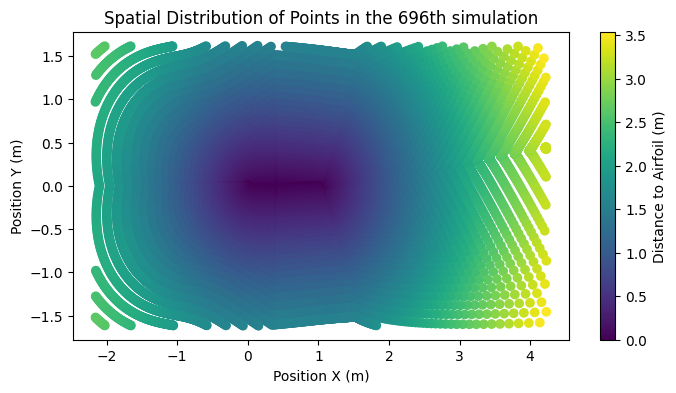

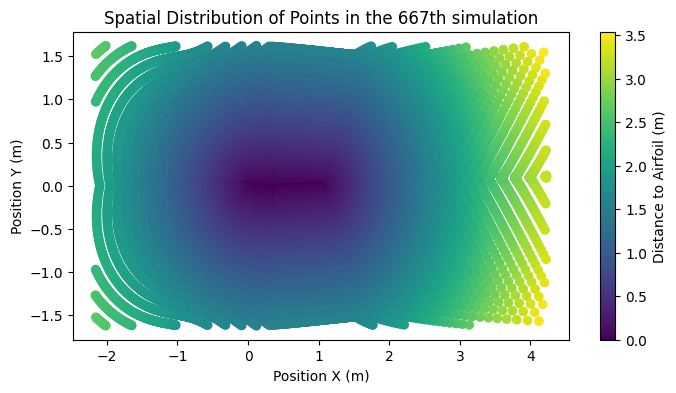

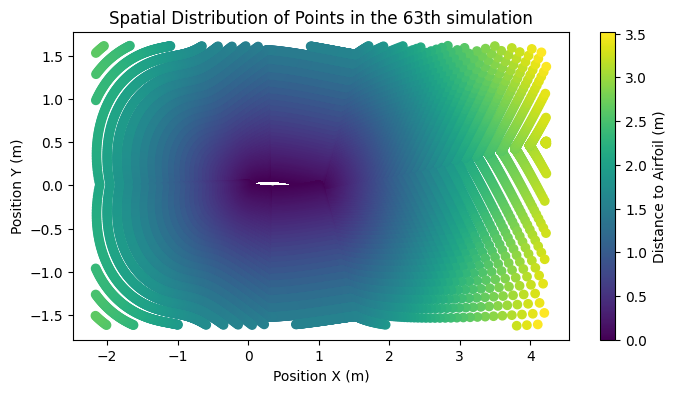

In [26]:
np.random.seed(42)

for i in np.random.choice(len(dataset_list), 3, replace = False):
    plt.figure(figsize=(8, 4))
    plt.scatter(dataset_list[i]["position_x"], dataset_list[i]["position_y"], c=dataset_list[i]["distance_to_airfoil"])
    plt.colorbar(label = "Distance to Airfoil (m)")
    plt.xlabel("Position X (m)")
    plt.ylabel("Position Y (m)")
    plt.title(f"Spatial Distribution of Points in the {i}th simulation")
    plt.show()

2. Inlet Velocity Field:

- These component represent the initial conditions of the velocity field at the inlet boundary of the simulation domain

- The inlet velocities set the initial flow conditions, which are crucial for solving NSE. They impact how fluid enters the domain and the subsequent develop of the flow field.

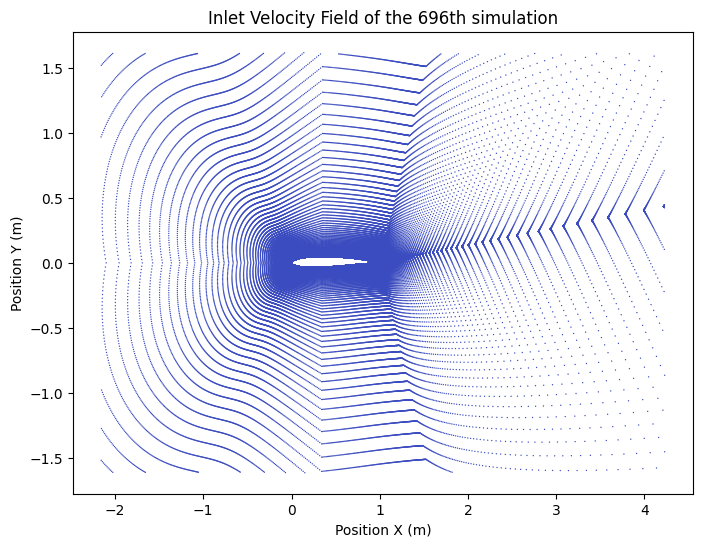

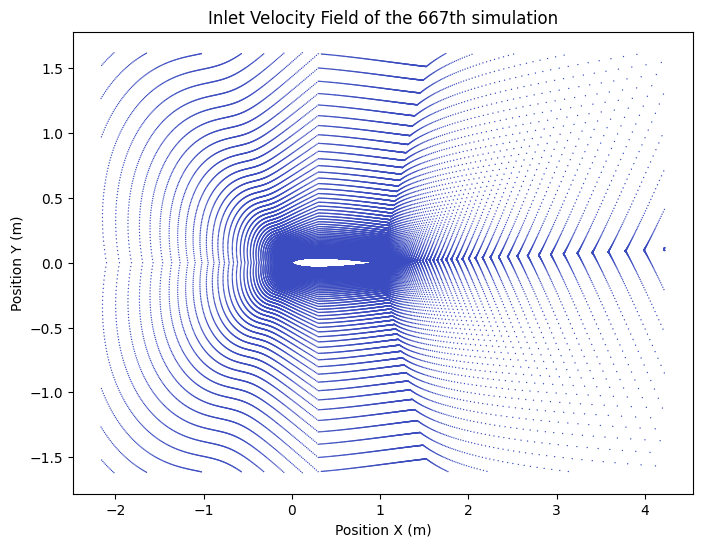

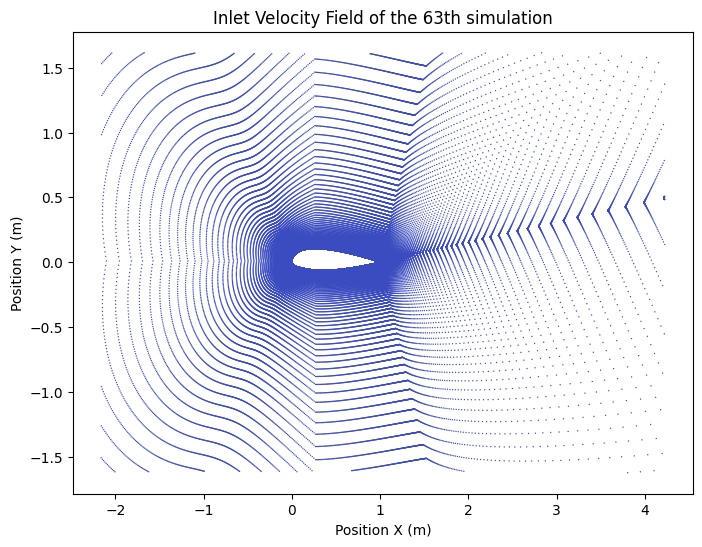

In [27]:
np.random.seed(42)

for i in np.random.choice(len(dataset_list), 3, replace = False):

    velocity_magnitude = np.sqrt(dataset_list[i]["inlet_velocity_u"].pow(2) + dataset_list[i]["inlet_velocity_v"].pow(2))

    plt.figure(figsize=(8, 6))
    plt.quiver(dataset_list[i]["position_x"], dataset_list[i]["position_y"], dataset_list[i]["inlet_velocity_u"], dataset_list[i]["inlet_velocity_v"], velocity_magnitude, cmap="coolwarm")
    plt.xlabel("Position X (m)")
    plt.ylabel("Position Y (m)")
    plt.title(f"Inlet Velocity Field of the {i}th simulation")
    plt.show()

3. Velocity Field:

The velocity fields $\mathbf{u}$ evolve according to the momentum equations, considering the affects of pressure gradients, viscous forces, and turbulence.

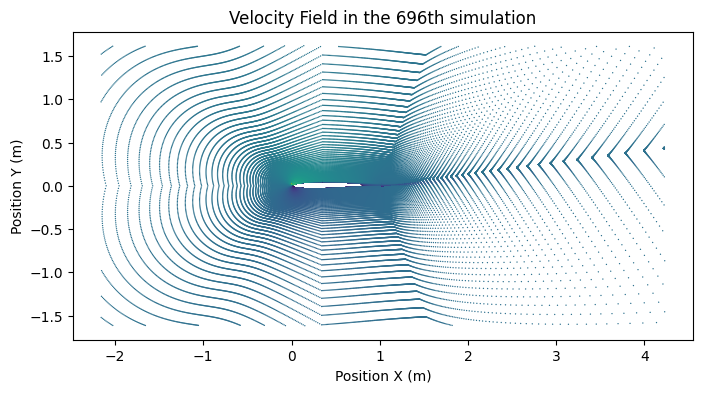

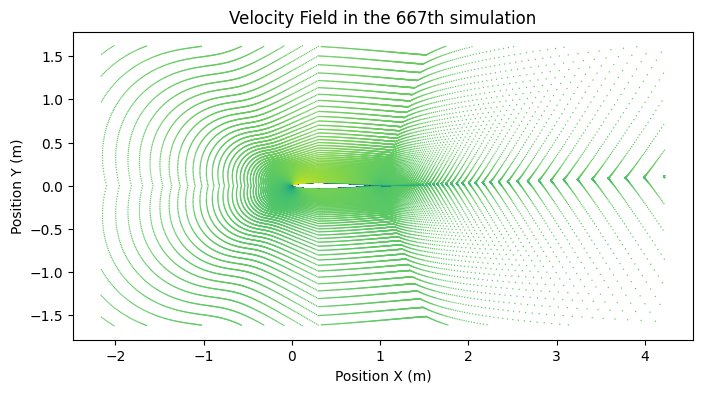

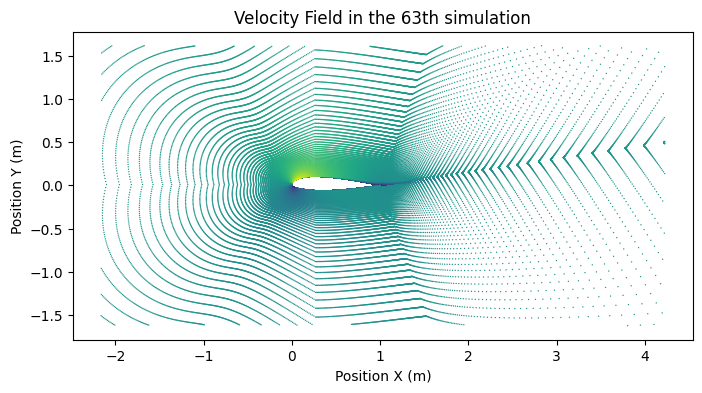

In [30]:
np.random.seed(42)

for i in np.random.choice(len(dataset_list), 3, replace = False):

    velocity_magnitude = np.sqrt(dataset_list[i]["velocity_u"].pow(2) + dataset_list[i]["velocity_v"].pow(2))

    plt.figure(figsize=(8, 4))
    plt.quiver(dataset_list[i]["position_x"], dataset_list[i]["position_y"], dataset_list[i]["velocity_u"], dataset_list[i]["velocity_v"], velocity_magnitude, cmap = "viridis")
    plt.xlabel("Position X (m)")
    plt.ylabel("Position Y (m)")
    plt.title(f"Velocity Field in the {i}th simulation")
    plt.show()

4. Pressure Distribution

- The pressure field $\mathbf{p}$ interacts with the velocity field through the momentum equations, affecting lift and drag forces on the airfoil.

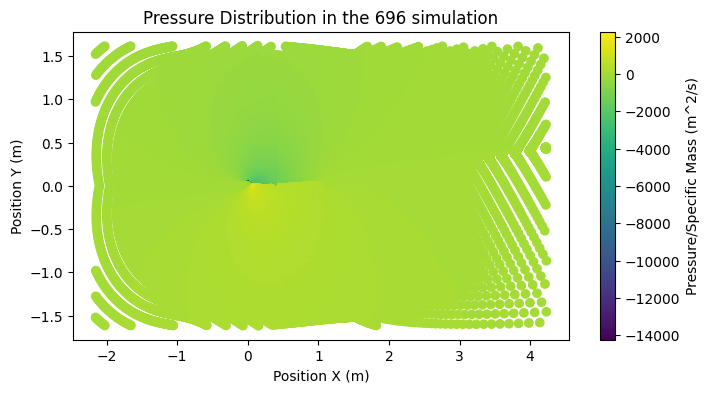

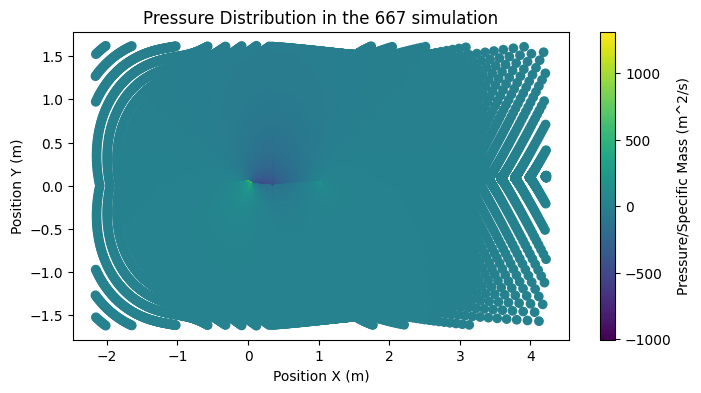

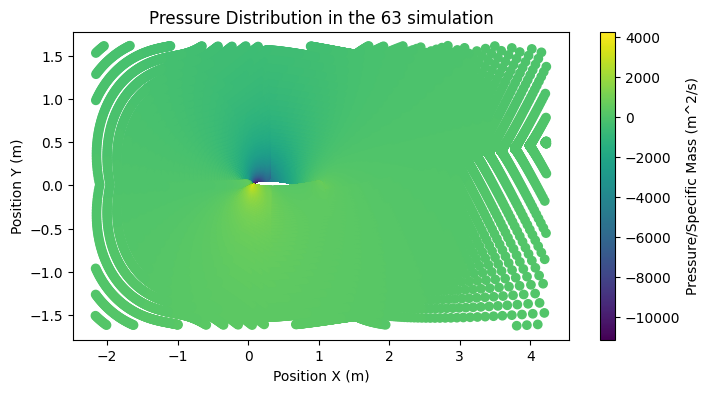

In [31]:
np.random.seed(42)

for i in np.random.choice(len(dataset_list), 3, replace = False):

    plt.figure(figsize=(8, 4))
    plt.scatter(dataset_list[i]["position_x"], dataset_list[i]["position_y"], c = dataset_list[i]["pressure_div_specific_mass"], cmap="viridis")
    plt.colorbar(label = "Pressure/Specific Mass (m^2/s)")
    plt.xlabel("Position X (m)")
    plt.ylabel("Position Y (m)")
    plt.title(f"Pressure Distribution in the {i} simulation")
    plt.show()

5. Turbulent Kinematic Viscosity

- It is the effective viscosity due to turbulence. Also, it modifies the momentum diffusion and represent the energy dissipation in the fluid.

c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


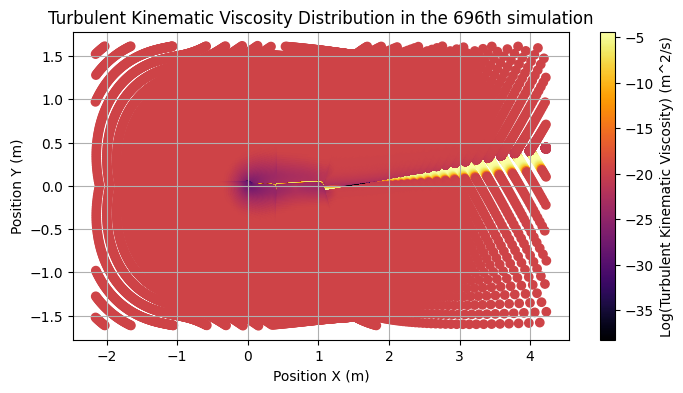

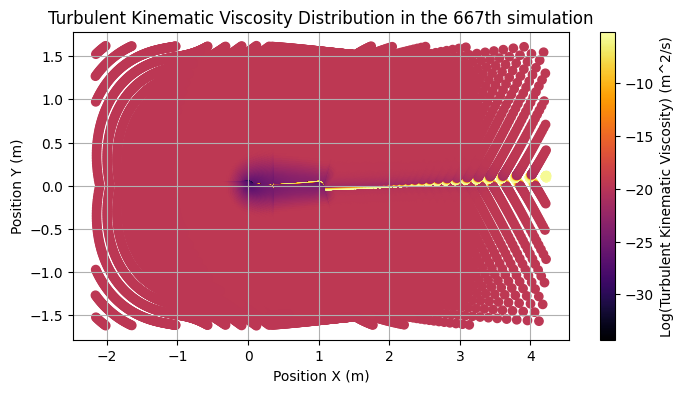

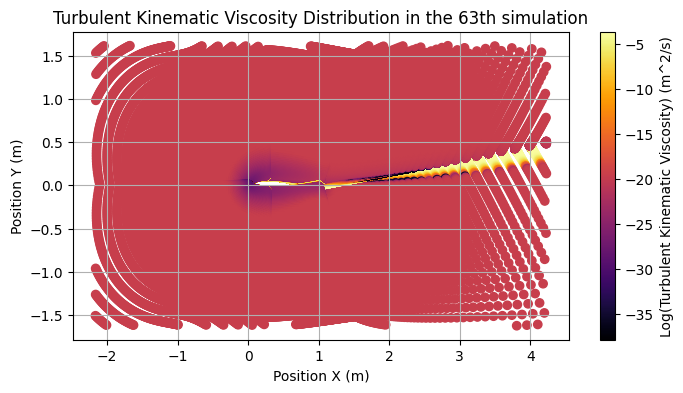

In [32]:
np.random.seed(42)

for i in np.random.choice(len(dataset_list), 3, replace = False):

    plt.figure(figsize=(8, 4))
    plt.scatter(dataset_list[i]["position_x"], dataset_list[i]["position_y"], c=np.log(dataset_list[i]["turbulent_kinematic_viscosity"]), cmap="inferno") # Plot in a log scale for better visual
    plt.colorbar(label = "Log(Turbulent Kinematic Viscosity) (m^2/s)")
    plt.xlabel("Position X (m)")
    plt.ylabel("Position Y (m)")
    plt.title(f"Turbulent Kinematic Viscosity Distribution in the {i}th simulation")
    plt.grid(True)
    plt.show()

6. Boundary 

- This plot below shows the velocity profiles at different chord position (10%, 50%, 90%) along the airfoil surface. 

- **Near Leading Edge (10%)**: The blue lines shows a thin boundary layer with a sharp increase in velocity, indicating the acceleration of the flow arround the leading edge.

- **Mid-Chord (50%)**: The orange line shows a thicker boundary layer compared to the leading edge.

- **Near Trailing Edge (90%)**: The green line indicates an even thicker boundary layer, reflecting further development and possibly higher turbulence level.


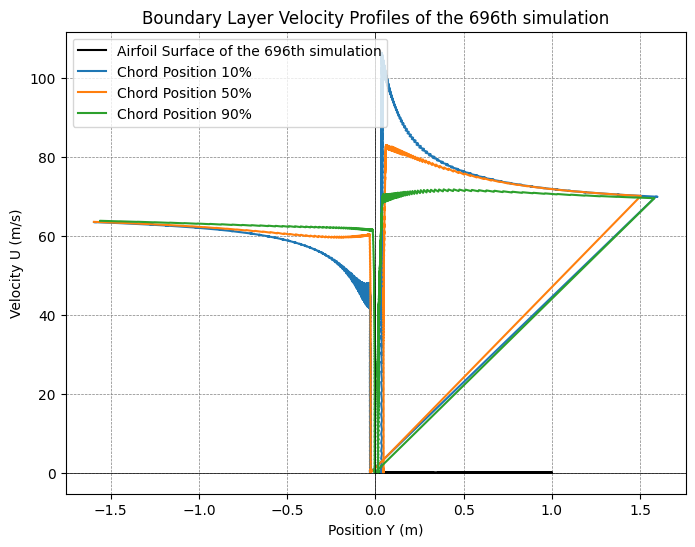

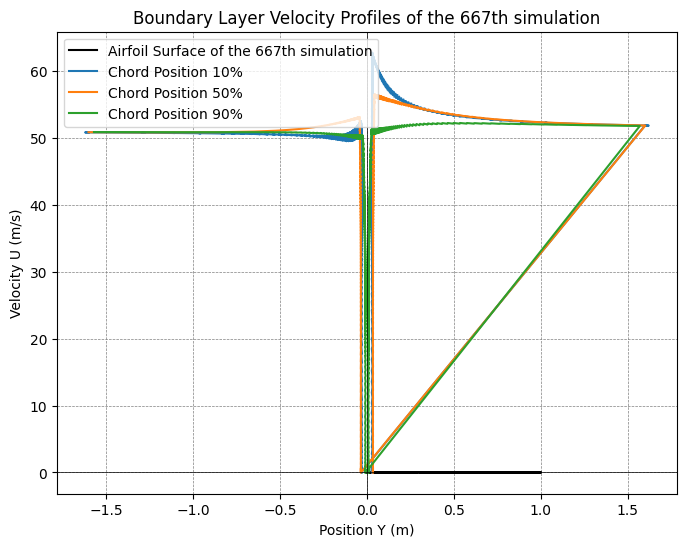

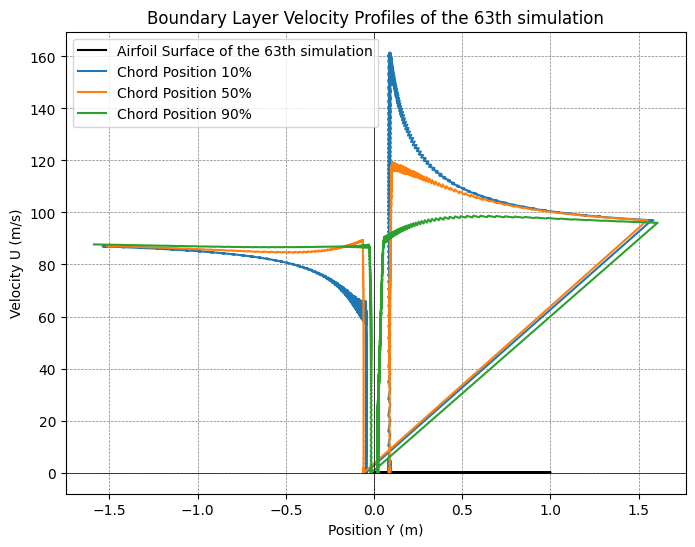

In [33]:
np.random.seed(42)

chord_positions = [0.1, 0.5, 0.9]  # Positions along the chord (10%, 50%, 90%)

for i in np.random.choice(len(dataset_list), 3, replace = False):

    plt.figure(figsize=(8, 6))

    airfoil_surface = dataset_list[i][dataset_list[i]['is_on_airfoil'] == 1]
    plt.plot(airfoil_surface["position_x"], airfoil_surface["position_y"], "k-", label= f"Airfoil Surface of the {i}th simulation")

    for chord in chord_positions:
        subset = dataset_list[i][np.abs(dataset_list[i]["position_x"] - chord) < 0.02]  # Filter points near the chord position
        plt.plot(subset["position_y"], subset["velocity_u"], label=f"Chord Position {chord * 100:.0f}%")
        
    plt.xlabel("Position Y (m)")
    plt.ylabel("Velocity U (m/s)")
    plt.title(f"Boundary Layer Velocity Profiles of the {i}th simulation")
    plt.axhline(0, color="black",linewidth=0.5)
    plt.axvline(0, color="black",linewidth=0.5)
    plt.grid(color = "gray", linestyle = "--", linewidth = 0.5)
    plt.legend()
    plt.show()

### Mesh generation

C-Grid: a type of structured mesh used in computational fluid dynamics (CFD) simulations. The name "C-Grid" derives from the way the grid wraps around the geometry, resembling the letter "C".

**Key features of C-Grid**:
1. Staggered Grid Arrangement:
- Velocity components: In 2D, the velocity components are stored at the edges of the grid cells, while the pressue is stored at the center of the grid cells.

2. Handling Complex Geometries:
- C-Grid mesh design to wraps arround an objects (i.e., airfoil) in a way that allows detailed resolution of boundary layers and flow features.

3. Advantages:
- The staggered arrangement help improve numerical stability.
- Also, provide a precise representation of the pressure-velocity coupling.

4. Boundary Conditions:
- Easy implement the boundary conditions, especialy on the solid boundaries where the no-slip condition can be directly applied.


The paper use a C-Grid mesh that was used for each airfoil. This type of mesh is the multi-block hexahedral mesh generator *blockMesh* from OpenFOAM v2112. The boundaries of the simulation domain were set at a distance of 200 chord lengths away from the airfoil. This help to minimize the influence of the boundary conditions on the simulation results, hence the flow near the airfoil can develop more naturally. The meshes used in these simulation contain between 250,000 to 300,000 cells.



### Discretization

- The simulations were conducted using the OpenFOAM software, which primarily employs the **Finite Volume Method** for discretizing the NSE. 

- The solver and algorithm was used for the compressible case is the SIMPLE (Semi-Implicit Method for Pressure-Linked Equations) algorithm and for the incompressible case is SIMPLEC (SIMPLE - Consistent). However, the paper only accounts for incompressible case.

- The simulations were run using the steady-state RANS solver *simple*FOAM via SIMPLEC algorithm and $k - \omega$ SST (Shear Stress Transport) model for turbulence modeling. 


### Navier-Stokes Equations

Recall the incompressible Navier-Stokes equations:

$$
\frac{\partial{\mathbf{u}}}{\partial{t}} + (\mathbf{u} \cdot \nabla)\mathbf{u} = - \nabla p + \frac{1}{Re} \nabla^2 \mathbf{u} \tag{1}
$$ 

$$
\nabla \cdot \mathbf{u} = 0 \tag{2}
$$

Where $\mathbf{u}(x,t) = \begin{bmatrix} u\\ v\end{bmatrix}$.

### Formulation of the Reynolds-Averaged Navier-Stokes Equations (RANS) in 2D

The RANS equations are formulated as follows:

- Let 
  $$
  \mathbf{u}(x,t) = \mathbf{\overline{u}}(x) + \mathbf{u'}(x,t) \tag{3}
  $$ 
  (aka, *Reynolds decomposition*)

  - $\mathbf{\overline{u}}(x)$ is the time-averaged (mean) component of the velocity.
  - $\mathbf{u'}(x,t)$ is the fluctuating component of the velocity.


  - Where 
    $$
    \mathbf{\overline{u}}(x) = \lim_{T \to \infty} \int_{0}^{T} \mathbf{u}(x,t) \, dt \tag{4}
    $$ 
    (aka, *Time-averaged value*)

     This represents the average velocity over an infinite time horizon.

Properties of averaging are:

$$\overline{u'} = 0 \\

\overline{u+v} = \bar{u} + \bar{v} \\

\overline{\overline{u}} = u \\

\overline{\bar{u}\cdot v} = \overline{u} \cdot \overline{v}$$

Note: $(\overline{uv} \neq \bar{u} \cdot \bar{v})$

$$ \left(\overline{\frac{\partial u}{\partial s}} \right) = \frac{\partial \bar{u}}{\partial s}$$

and
$$\overline{u'^{2}} \neq 0$$


### RANS Equations

1. With the Reynolds decomposition, the continuity equation become:

   $$
   \nabla \cdot \left(\mathbf{\overline{u}} + \mathbf{u'}\right) = \frac{\partial{\bar{u}}}{\partial{x}} + \frac{\partial{\bar{v}}}{\partial{y}} + \frac{\partial{u'}}{\partial{x}} + \frac{\partial{v'}}{\partial{y}} = 0 \tag{5}
   $$

   - Taking the time average, we have:

      $$
      \frac{\partial{\bar{u}}}{\partial{x}} + \frac{\partial{\bar{v}}}{\partial{y}} = 0 \tag{6}
      $$

   - Therefore, 

      $$
      \nabla \cdot \mathbf{\overline{u}} = 0 \tag{7}
      $$

   - Substracting equation (6) from equation (5), we obtain:

      $$
      \frac{\partial{u'}}{\partial{x}} + \frac{\partial{v'}}{\partial{y}} = 0 \tag{8}
      $$

   - Hence,

      $$
      \nabla \cdot \mathbf{u'} = 0 \tag{9}
      $$

   Note that the mean and the fluctuating velocities individually satisfy the continuity equation. 

2. Substitute the Reynolds decomposition into the momemtum equation and simplify:
   $$
   (\mathbf{\overline{u}} \cdot \nabla) \mathbf{\overline{u}} = -\nabla \overline{p} + \frac{1}{Re} \nabla^2 \mathbf{\overline{u}} - \nabla \cdot \overline{\mathbf{u'} \mathbf{u'}} \tag{10}
   $$

   Where $- \nabla \cdot \overline{\mathbf{u'} \mathbf{u'}}$ is the *Reynold Stress*


More details on Section 7.1, 7.2, 7.3 of http://profs.sci.univr.it/~zuccher/downloads/FD-MAE553-Smits.pdf

<br>

In Einstein summation notation:

- For the continuity equation:
   $$
   \partial_{i}{\bar{u}_i} = 0 \tag{11}
   $$

- For the momemtum equation:
   $$
   \partial_{j}{\left( \bar{u}_i\bar{u}_j \right)} = - \partial_{i}{\left (\frac{\bar{p}}{\rho} \right)} + \left(\nu + \nu_{t}\right) \partial_{jj}^2 \bar{u}_i, \quad i \in \{1, 2\} \tag{12}
   $$



### Quantities that differ among the samples in dataset are:

1. Airfoil Shape: Each sample is defined by a unique airfoil geometry.

2. Reynolds Number: Difference samples have different Reynolds numbers.

3. Angle of Attack: Each sample have a different angle of attack.